In [41]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from ladder import ladder_up

In [ ]:
def neqr(intensity, x, y, image):
    intensity_bits = len(intensity)
    num_x_bits = len(x)
    num_y_bits = len(y)
    position = list(x) + list(y)
    position_bits = num_x_bits + num_y_bits
    qc = QuantumCircuit(intensity, position, name="NEQR")

    flat_image = image.flatten()

    for pos in range(2 ** position_bits):
        pixel_intensity = int(flat_image[pos])
        bin_intensity = format(pixel_intensity, f'0{intensity_bits}b')[::-1] 
        control_bits = format(pos, f'0{position_bits}b')[::-1] 

        controls = []
        for j, cb in enumerate(control_bits):
            qubit = intensity_bits + j
            if cb == '0':
                qc.x(qubit)
            controls.append(qubit)

        for i, bit in enumerate(bin_intensity):
            if bit == '1':
                qc.mcx(controls, i)

        # Uncompute X gates
        for j, cb in enumerate(control_bits):
            if cb == '0':
                qc.x(intensity_bits + j)

    return qc.to_gate()


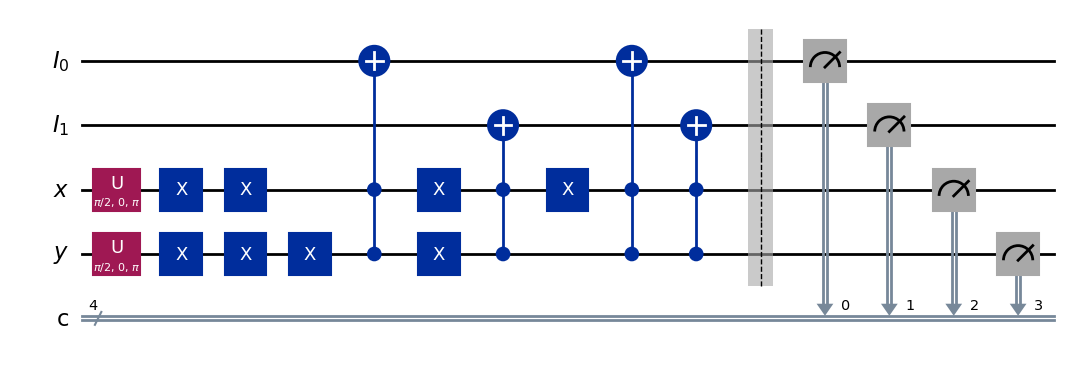

In [ ]:
num_bits = 2
x_val = 3
y_val = 7
num_total_qubits = 2 * num_bits + 1
intensity = QuantumRegister(4,name='I')
x = QuantumRegister(num_bits, name='x')
y = QuantumRegister(num_bits, name='y')
cr = ClassicalRegister(8, name = 'c')
qc = QuantumCircuit(intensity,x,y,cr)
image = np.array([
    [0, 1,2,3],
    [4,5,6,7],
    [8,9,10,11],
    [12,13,14,15]
])
qc.h(x)
qc.h(y)
qc.append(neqr(intensity,x,y,image), list(intensity) + list(x) + list(y))
#qc.append(ladder_up(x),list(x))
qc.barrier()
qc.measure(list(intensity) + list(x) + list(y), list(cr))
qc.decompose().draw('mpl')

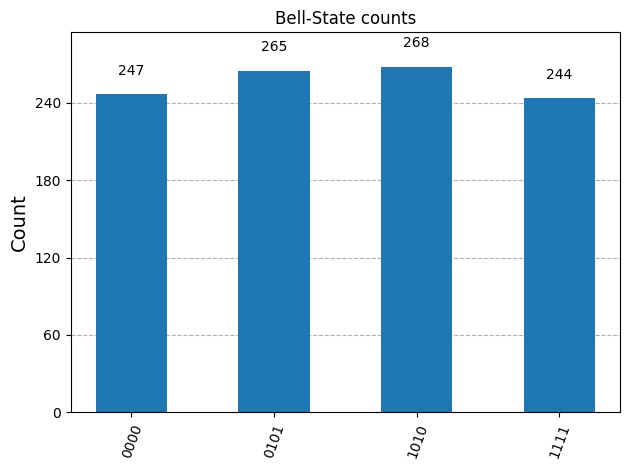

In [44]:
simulator = AerSimulator()
circ = transpile(qc, simulator)

result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')